In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

from gym import wrappers

env = gym.make('CarRacing-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/alexpc/anaconda3/envs/rlenv/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 6) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [4]:
net = DQN(35, 50)
print(net)

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=96, out_features=6, bias=True)
)


Track generation: 1145..1435 -> 290-tiles track


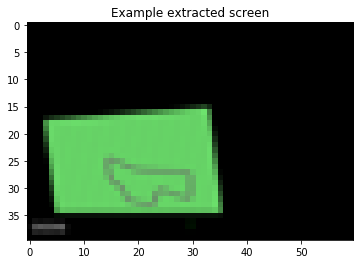

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])



def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Strip off the edges, so that we have a square image centered on a cart
    #screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest value for column of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
   # print(batch)
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    #print(batch.action)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [9]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    score_buf = 0 
    print('current episode: ', i_episode)
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action_space = {
                        0 : [1, 0, 0],
                        1 : [-1, 0 , 0],
                        2 : [0, 1, 0],
                        3 : [0, 0, 1],
                        4 : [1, 1, 0],
                        5 : [-1, 1 , 0],
        }
        action = select_action(state)
        _, reward, done, _ = env.step(action_space[int(action)])
        score_buf += reward
        reward = torch.tensor([reward], device=device)
        print("score_buf:", score_buf)
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        #print("type(action): ", type(action))
        #print(action)
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done or score_buf < -1:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [10]:
env.reset()
score_buf = 0 
print('current episode: ', i_episode)
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

action_space = {
                        0 : [1, 0, 0],
                        1 : [-1, 0 , 0],
                        2 : [0, 1, 0],
                        3 : [0, 0, 1],
                        4 : [1, 1, 0],
                        5 : [-1, 1 , 0],
        }
action = policy_net(state).max(1)[1].view(1, 1)
_, reward, done, _ = env.step(action_space[int(action)])
score_buf += reward
reward = torch.tensor([reward], device=device)
print("score_buf:", score_buf)
    # Observe new state
last_screen = current_screen
current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
        else:
            next_state = None

Track generation: 1207..1513 -> 306-tiles track
current episode:  49
score_buf: 6.457377049180328
score_buf: 6.357377049180329
score_buf: 6.257377049180329
score_buf: 6.1573770491803295
score_buf: 6.05737704918033
score_buf: 5.95737704918033
score_buf: 5.8573770491803305
score_buf: 5.757377049180331
score_buf: 5.657377049180331
score_buf: 5.557377049180332
score_buf: 5.457377049180332
score_buf: 5.357377049180332
score_buf: 5.257377049180333
score_buf: 5.157377049180333
score_buf: 5.057377049180333
score_buf: 4.957377049180334
score_buf: 4.857377049180334
score_buf: 4.757377049180334
score_buf: 4.657377049180335
score_buf: 4.557377049180335
score_buf: 4.4573770491803355
score_buf: 4.357377049180336
score_buf: 4.257377049180336
score_buf: 4.157377049180337
score_buf: 4.057377049180337
score_buf: 3.957377049180337
score_buf: 3.8573770491803367
score_buf: 3.7573770491803367
score_buf: 3.6573770491803366
score_buf: 3.5573770491803365
score_buf: 3.4573770491803364
score_buf: 3.3573770491803

score_buf: -20.742622950819694
score_buf: -20.842622950819695
score_buf: -20.942622950819697
score_buf: -21.0426229508197
score_buf: -21.1426229508197
score_buf: -21.2426229508197
score_buf: -21.342622950819703
score_buf: -21.442622950819704
score_buf: -21.542622950819705
score_buf: -21.642622950819707
score_buf: -21.742622950819708
score_buf: -21.84262295081971
score_buf: -21.94262295081971
score_buf: -22.042622950819712
score_buf: -22.142622950819714
score_buf: -22.242622950819715
score_buf: -22.342622950819717
score_buf: -22.442622950819718
score_buf: -22.54262295081972
score_buf: -22.64262295081972
score_buf: -22.742622950819722
score_buf: -22.842622950819724
score_buf: -22.942622950819725
score_buf: -23.042622950819727
score_buf: -23.142622950819728
score_buf: -23.24262295081973
score_buf: -23.34262295081973
score_buf: -23.442622950819732
score_buf: -23.542622950819734
score_buf: -23.642622950819735
score_buf: -23.742622950819737
score_buf: -23.842622950819738
score_buf: -23.94262

score_buf: -47.74262295082008
score_buf: -47.84262295082008
score_buf: -47.94262295082008
score_buf: -48.04262295082008
score_buf: -48.14262295082008
score_buf: -48.242622950820085
score_buf: -48.342622950820086
score_buf: -48.44262295082009
score_buf: -48.54262295082009
score_buf: -48.64262295082009
score_buf: -48.74262295082009
score_buf: -48.84262295082009
score_buf: -48.942622950820095
score_buf: -49.042622950820096
score_buf: -49.1426229508201
score_buf: -49.2426229508201
score_buf: -49.3426229508201
score_buf: -49.4426229508201
score_buf: -49.5426229508201
score_buf: -49.642622950820105
score_buf: -49.742622950820106
score_buf: -49.84262295082011
score_buf: -49.94262295082011
score_buf: -50.04262295082011
score_buf: -50.14262295082011
score_buf: -50.24262295082011
score_buf: -50.342622950820115
score_buf: -50.442622950820116
score_buf: -50.54262295082012
score_buf: -50.64262295082012
score_buf: -50.74262295082012
score_buf: -50.84262295082012
score_buf: -50.94262295082012
score_b

KeyboardInterrupt: 

In [13]:
num_episodes = 2
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    score_buf = 0 
    print('current episode: ', i_episode)
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action_space = {
                        0 : [1, 0, 0],
                        1 : [-1, 0 , 0],
                        2 : [0, 1, 0],
                        3 : [0, 0, 1],
                        4 : [1, 1, 0],
                        5 : [-1, 1 , 0],
        }
        action = policy_net(state).max(1)[1].view(1, 1)
        _, reward, done, _ = env.step(action_space[int(action)])
        score_buf += reward
        print("score_buf:", score_buf)
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
            
        state = next_state
        
        if done or score_buf < -1:
            episode_durations.append(t + 1)
            plot_durations()
            break

Track generation: 1216..1524 -> 308-tiles track
current episode:  0


ArgumentError: argument 2: <class 'TypeError'>: wrong type